## Phase 5 - Forecasting with ARIMA (Headcount / Salary Totals)

### Import Statements

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

In [2]:
PROC_PATH = Path("../data/processed")
FORE_PATH = Path("../data/forecasting")
VISUAL_PATH = Path("../visualizations")

In [3]:
# Load headcount data
df = pd.read_csv(PROC_PATH / "hire_trend.csv")
print("Loaded:", df.shape)
df.head()

Loaded: (20, 3)


,department,year,headcount
0,Admin Offices,2013,2
1,Admin Offices,2014,3
2,Admin Offices,2015,5
3,Admin Offices,2016,1
4,Executive Office,2016,1


In [4]:
# Convert to datetime for time-series
df["date"] = pd.to_datetime(df["year"].astype(str) + "-12-31")
departments = df["department"].unique()

In [5]:
forecast_results = []
FORECAST_HORIZON = 3  # 3 future years

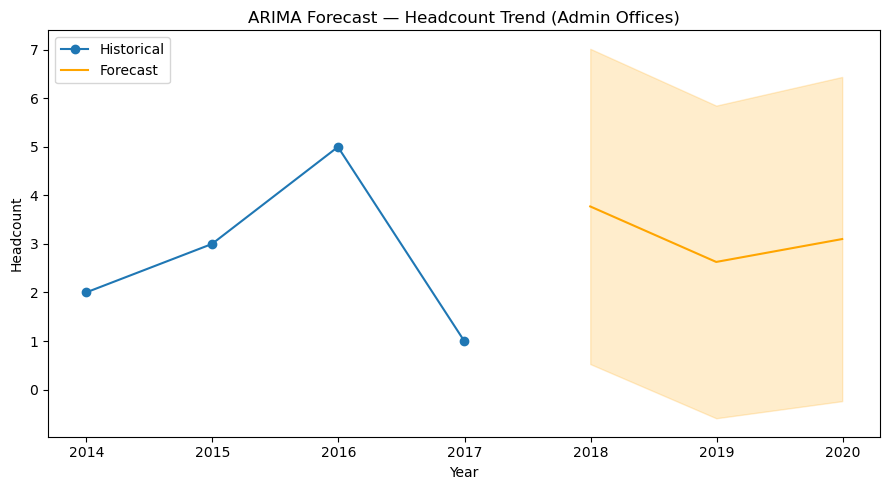

ARIMA forecast complete for Admin Offices


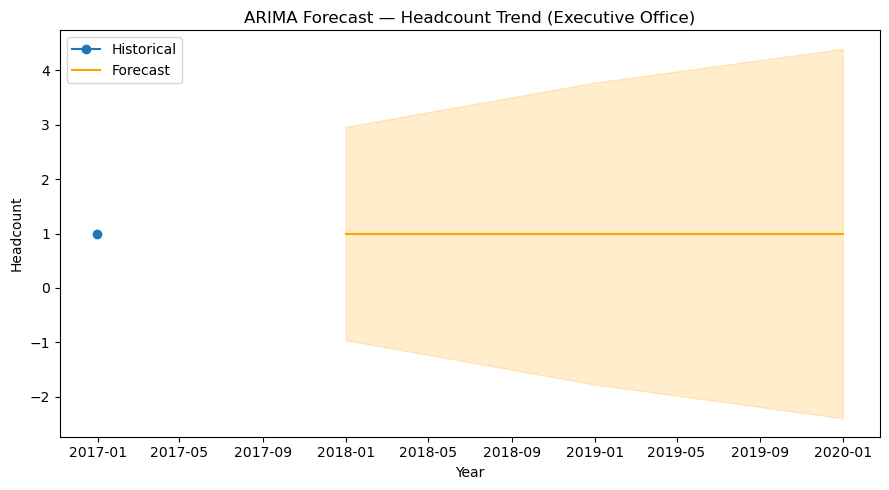

ARIMA forecast complete for Executive Office


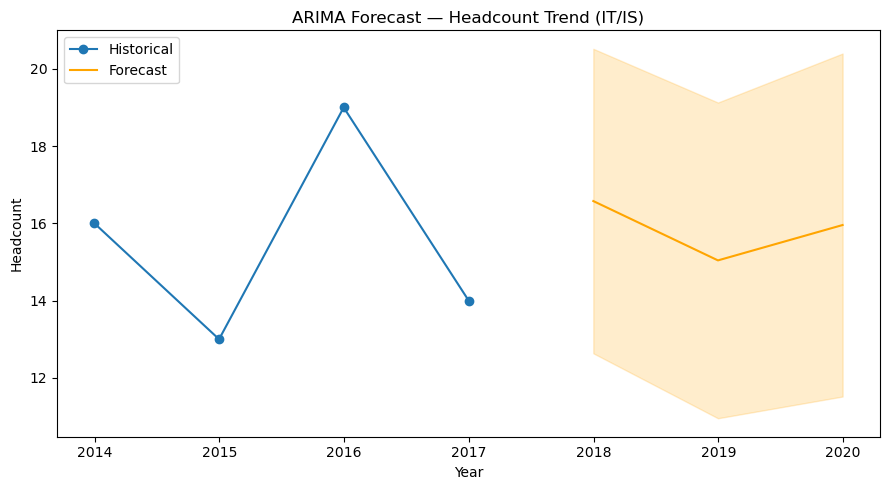

ARIMA forecast complete for IT/IS


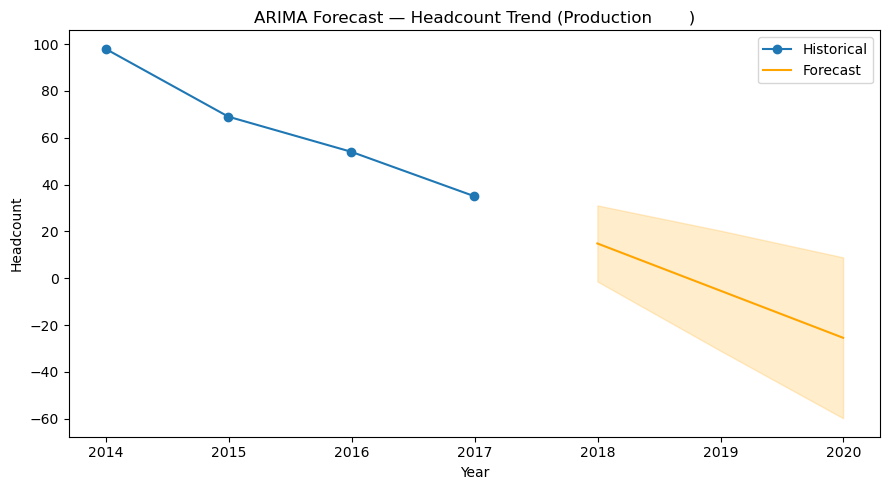

ARIMA forecast complete for Production       


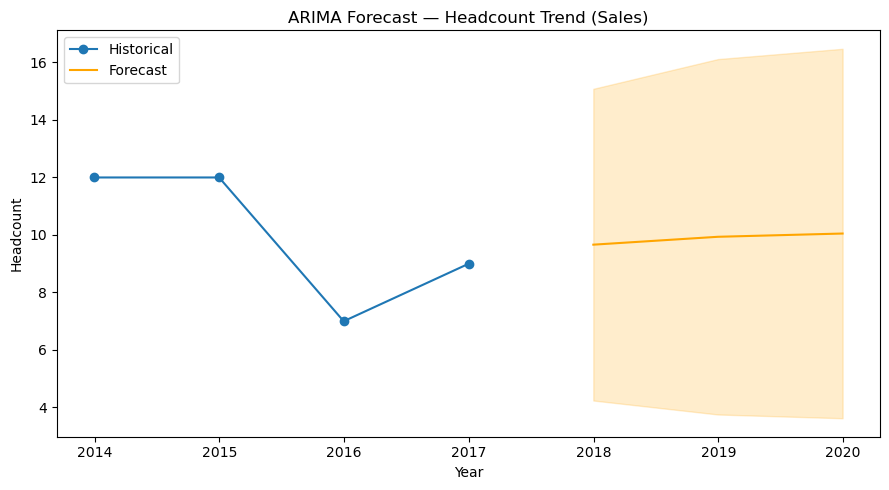

ARIMA forecast complete for Sales


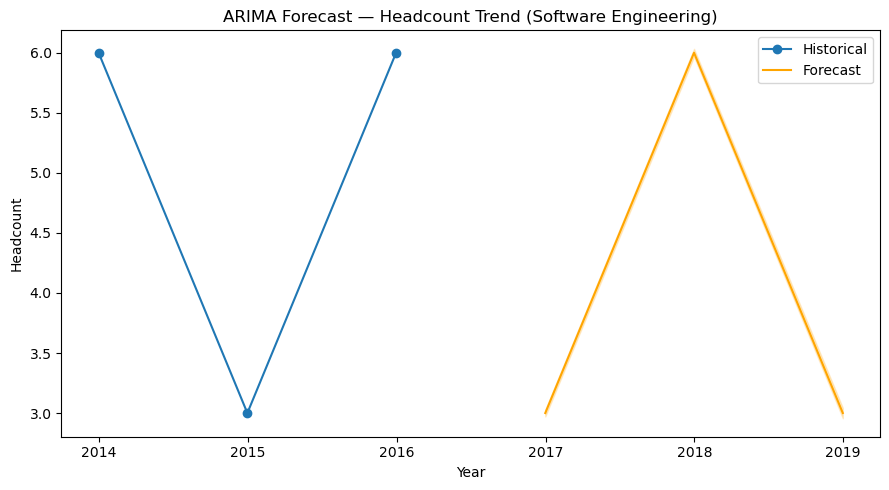

ARIMA forecast complete for Software Engineering


In [6]:
for dept in departments:
    sub = df[df["department"] == dept].sort_values("date")
    y = sub["headcount"].values
    years = sub["date"].values
    
    # Simple ARIMA(1,1,1)
    model = SARIMAX(sub["headcount"], order=(1,1,1), seasonal_order=(0,0,0,0))
    fit = model.fit(disp=False)

    # Forecast future
    forecast = fit.get_forecast(steps=FORECAST_HORIZON)
    pred = forecast.predicted_mean
    conf = forecast.conf_int(alpha=0.05)

    future_dates = pd.date_range(start=sub["date"].max() + pd.offsets.YearEnd(),
                                 periods=FORECAST_HORIZON, freq="Y")

    # Combine
    forecast_df = pd.DataFrame({
        "department": dept,
        "ds": future_dates,
        "yhat": pred.values,
        "yhat_lower": conf.iloc[:,0].values,
        "yhat_upper": conf.iloc[:,1].values
    })
    forecast_results.append(forecast_df)

    # Plot
    plt.figure(figsize=(9,5))
    plt.plot(sub["date"], sub["headcount"], label="Historical", marker="o")
    plt.plot(future_dates, pred, label="Forecast", color="orange")
    plt.fill_between(future_dates, conf.iloc[:,0], conf.iloc[:,1], alpha=0.2, color="orange")
    plt.title(f"ARIMA Forecast — Headcount Trend ({dept})")
    plt.xlabel("Year")
    plt.ylabel("Headcount")
    plt.legend()
    plt.tight_layout()
    plt.show()

    fig_name = dept.strip()
    fig_name = re.sub(r'[^A-Za-z0-9]+', '_', fig_name) 
    fig_name = re.sub(r'_+', '_', fig_name).strip('_').lower()
    plt.savefig(VISUAL_PATH / f"arima_headcount_{fig_name}.png", dpi=120)
    plt.close()

    print(f"ARIMA forecast complete for {dept}")

In [7]:
# Combine & save
arima_df = pd.concat(forecast_results, ignore_index=True)
arima_df.to_csv(FORE_PATH/"arima_headcount_forecasts.csv", index=False)
print("All ARIMA forecasts saved successfully!")

All ARIMA forecasts saved successfully!


In [9]:
metrics = []
skipped = []

for dept in departments:
    sub = df[df["department"].astype(str).str.strip() == dept].sort_values("date").copy()
    sub = sub.dropna(subset=["headcount"])  # just in case

    # Need at least 3 points to fit ARIMA(1,1,1) sensibly
    if len(sub) < 3:
        skipped.append((dept, len(sub)))
        metrics.append({
            "department": dept, "RMSE": np.nan, "MAE": np.nan, "MAPE (%)": np.nan,
            "ADF_pvalue": np.nan, "n_obs": len(sub), "status": "skipped(<3 obs)"
        })
        continue

    # Use a DatetimeIndex so predictions align by index
    y = sub.set_index("date")["headcount"]

    try:
        fit = SARIMAX(y, order=(1,1,1), seasonal_order=(0,0,0,0)).fit(disp=False)

        # In-sample predictions aligned to index; first few may be NaN due to differencing
        insample = fit.get_prediction()
        yhat = insample.predicted_mean

        # Align actuals and preds on common index and drop NaNs
        aligned = pd.concat([y.rename("y"), yhat.rename("yhat")], axis=1).dropna()

        rmse = np.sqrt(mean_squared_error(aligned["y"], aligned["yhat"]))
        mae = mean_absolute_error(aligned["y"], aligned["yhat"])
        mape = (np.abs((aligned["y"] - aligned["yhat"]) / aligned["y"]).mean() * 100)

        # ADF can fail on tiny/flat series; wrap it
        try:
            adf_p = adfuller(y)[1]
        except Exception:
            adf_p = np.nan

        metrics.append({
            "department": dept,
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": round(mape, 2),
            "ADF_pvalue": adf_p,
            "n_obs": int(len(sub)),
            "status": "ok"
        })

    except Exception as e:
        metrics.append({
            "department": dept, "RMSE": np.nan, "MAE": np.nan, "MAPE (%)": np.nan,
            "ADF_pvalue": np.nan, "n_obs": int(len(sub)),
            "status": f"fit_error: {e.__class__.__name__}"
        })

metrics_df = pd.DataFrame(metrics).sort_values(["status","RMSE"], na_position="last")
metrics_df.to_csv(FORE_PATH / "arima_eval_metrics.csv", index=False)
display(metrics_df.head(10))

if skipped:
    print("Skipped (too few observations):", skipped)

,department,RMSE,MAE,MAPE (%),ADF_pvalue,n_obs,status
0,Admin Offices,1.926700,1.823817,86.59,0.343249,4,ok
5,Software Engineering,3.872976,3.000022,66.67,NaN,3,ok
4,Sales,6.500778,4.300420,43.42,0.738688,4,ok
2,IT/IS,8.341773,5.796829,36.55,0.070342,4,ok
1,Executive Office,NaN,NaN,NaN,NaN,1,skipped(<3 obs)
3,Production,NaN,NaN,NaN,NaN,0,skipped(<3 obs)


Skipped (too few observations): [('Executive Office', 1), ('Production       ', 0)]


### Analysis:

**Context:**
Prophet is producing solid compensation forecasts after building quarterly data.
<br>
ARIMA was explored for headcount using yearly data.


**Why ARIMA is on hold?**
ARIMA needs a little history to learn patterns. Most departments only have four annual points and a few have almost none. That is not enough to estimate reliable parameters.
<br>
Gaps across departments make it tricky as well. Headcount is a discrete operational number, so filling missing years can bend the story.
Evaluation is noisy on tiny samples. MAPE can look harsh when denominators are small, so error numbers appear worse than they feel.
With only a handful of annual points there is little autocorrelation or seasonality to pick up. The model ends up learning almost nothing.
Publishing headcount forecasts from such thin evidence could mislead planning. The safer path is to ship only the signal that is trustworthy today.

**What goes forward now:**
Prophet for compensation at this point stays. Fits are stable and easy to explain, with tight confidence bands for most departments and natural volatility for Sales.
<br>
If a quick view of headcount is needed, an ETS or Holt smoothing preview can be shared with clear caveats. That approach behaves better with very short series.

**When ARIMA makes sense to resume:**
More history per department. Eight to ten time points is a good rule of thumb. Quarterly snapshots for two to three years or annual data for eight to ten years both work.
- Better coverage across departments. Minimal gaps by period builds confidence.
- Series that look stationary after differencing or that clearly show a seasonal pattern.
- ACF and PACF charts with meaningful lags rather than flat lines.
- Rolling backtests that deliver stable errors using sMAPE or MASE.
- Stakeholders are comfortable with the intervals and a measurable lift over simple baselines.

**Steps to include ARIMA:**
- Shift headcount to quarterly snapshots to gain data points without waiting years.
- Extend the history if earlier extracts exist. Even a couple of extra years help.
- Standardize how headcount is defined, such as FTE versus simple count, and use one consistent as of date per period.
- Set up rolling evaluation so choices of p d q are tested across time instead of a single split.